In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [260]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [261]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import numpy as np

In [262]:
from tqdm import tqdm

In [263]:
from matplotlib import pyplot as plt
%matplotlib inline

In [264]:
np.random.seed = 42

In [297]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.lam = Parameter('Lambda')
        self.theta2 = Parameter('Theta2')
        self.phi2 = Parameter('Phi2')
        self.lam2 = Parameter('Lambda2')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(2,'q')
            cr = ClassicalRegister(2,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.h(qr[1])
            ckt.cx(0,1)
            ckt.barrier()
            ckt.u3(self.theta,self.phi,self.lam,qr[0])
            ckt.u3(self.theta2,self.phi2,self.lam2,qr[1])
            ckt.barrier()
            ckt.cx(1,0)
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = 0
        for key in counts.keys():
            perc = counts[key]/shots
            #check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            check = (float(key[0])-1/2)*2*(float(key[1])-1/2)*2*perc
            expects += check   
        return [expects]    
    
    def bind(self, parameters):
        #print(to_numbers(parameters))
        [self.theta,self.phi,self.lam] = to_numbers(parameters)[0:3]
        [self.theta2,self.phi2,self.lam2] = to_numbers(parameters)[3:6]
        self.circuit.data[4][0]._params = to_numbers(parameters)[0:3]
        self.circuit.data[5][0]._params = to_numbers(parameters)[3:6]
    
    def run(self, i):
        self.bind(i)
        
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,2)

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=10000)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        #print(result)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors    
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps

            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))[0]
            result_eps = torch.tensor([exp_value])
            gradient_result = (exp_value - forward_tensor[0][0].item())/eps
            gradient.append(gradient_result)
            
#         print(gradient)
        result = torch.tensor([gradient])
#         print(result)
        #print("test tens size", result.float(), grad_output.float())
        return result.float() * grad_output.float()

In [298]:
torch.manual_seed(42)

In [299]:
# x = torch.tensor([np.pi/4, np.pi/4, np.pi/4], requires_grad=True)
x = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print(y1)
y1.backward()
print(x.grad)

tensor([[0.]], grad_fn=<TorchCircuitBackward>)
tensor([[-0.9200, -1.3600, -1.0200, -0.4400, -1.6600,  0.2600]])


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


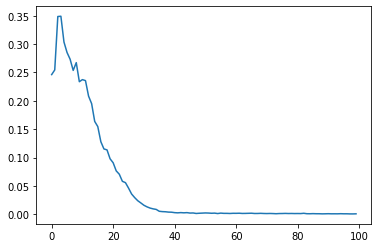

In [300]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)
    return torch.abs(qc(x).sum() - target) ** 2, expval

x = torch.tensor([[np.pi/4, np.pi/4, np.pi/4, np.pi/4, np.pi/4, np.pi/4]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

### MNIST in pytorch

In [301]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [302]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

batch_size_train = 1
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0][0:10],idx2[0][0:10])) # concatenate their indices
#idx = idx2
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

Dataset MNIST
    Number of datapoints: 20
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [306]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 6)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #x = np.pi*F.tanh(x)
        #print(x)
        x = qc(x)
#         print(x)
        x = (x+1)/4
        x = torch.cat((x, 1-x), -1)
        return x
#         return F.softmax(x)

In [307]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [308]:
epochs = 100
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(batch_idx)
        optimizer.zero_grad()
        output = network(data)
        print(output[0].data, target)
        loss = F.nll_loss(output, target)
#         print(output)
#         print(output[0][1].item(), target.item())
        #print(loss)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    print(sum(total_loss)/len(total_loss))

tensor([0.3029, 0.6971]) tensor([0])
tensor([0.2821, 0.7179]) tensor([0])
tensor([0.2913, 0.7087]) tensor([1])
tensor([0.2585, 0.7415]) tensor([0])
tensor([0.2645, 0.7355]) tensor([1])
tensor([0.3268, 0.6732]) tensor([0])
tensor([0.2803, 0.7197]) tensor([1])
tensor([0.3012, 0.6988]) tensor([0])
tensor([0.3076, 0.6924]) tensor([1])
tensor([0.2727, 0.7272]) tensor([1])
tensor([0.2502, 0.7498]) tensor([0])
tensor([0.2838, 0.7162]) tensor([1])
tensor([0.2253, 0.7747]) tensor([0])
tensor([0.2722, 0.7278]) tensor([1])
tensor([0.2677, 0.7322]) tensor([1])
tensor([0.2521, 0.7479]) tensor([0])
tensor([0.2526, 0.7474]) tensor([0])
tensor([0.2938, 0.7062]) tensor([1])
tensor([0.3167, 0.6833]) tensor([0])
tensor([0.3390, 0.6610]) tensor([1])
-0.49475999623537065
tensor([0.3458, 0.6543]) tensor([1])
tensor([0.2742, 0.7258]) tensor([1])
tensor([0.2515, 0.7485]) tensor([1])
tensor([0.2414, 0.7585]) tensor([0])
tensor([0.2740, 0.7261]) tensor([0])
tensor([0.2729, 0.7271]) tensor([1])
tensor([0.2689, 0

tensor([0.3015, 0.6985]) tensor([1])
tensor([0.2824, 0.7176]) tensor([0])
tensor([0.3167, 0.6833]) tensor([1])
tensor([0.2761, 0.7240]) tensor([0])
-0.5047850027680397
tensor([0.2877, 0.7123]) tensor([1])
tensor([0.3923, 0.6077]) tensor([0])
tensor([0.3018, 0.6982]) tensor([0])
tensor([0.2643, 0.7357]) tensor([1])
tensor([0.2831, 0.7169]) tensor([1])
tensor([0.4022, 0.5978]) tensor([1])
tensor([0.2783, 0.7217]) tensor([1])
tensor([0.2988, 0.7012]) tensor([0])
tensor([0.2736, 0.7264]) tensor([1])
tensor([0.2747, 0.7254]) tensor([0])
tensor([0.2713, 0.7286]) tensor([0])
tensor([0.2740, 0.7260]) tensor([0])
tensor([0.2876, 0.7124]) tensor([0])
tensor([0.3049, 0.6951]) tensor([0])
tensor([0.2718, 0.7282]) tensor([0])
tensor([0.2777, 0.7223]) tensor([1])
tensor([0.2803, 0.7197]) tensor([1])
tensor([0.3941, 0.6059]) tensor([1])
tensor([0.3831, 0.6169]) tensor([1])
tensor([0.2819, 0.7181]) tensor([0])
-0.4917274996638298
tensor([0.3002, 0.6998]) tensor([1])
tensor([0.2862, 0.7138]) tensor([0]

tensor([0.3168, 0.6832]) tensor([1])
tensor([0.3340, 0.6660]) tensor([0])
tensor([0.3007, 0.6993]) tensor([1])
tensor([0.3058, 0.6942]) tensor([1])
tensor([0.3279, 0.6721]) tensor([0])
tensor([0.3130, 0.6870]) tensor([0])
tensor([0.3228, 0.6773]) tensor([1])
tensor([0.2965, 0.7035]) tensor([1])
-0.5046300008893013
tensor([0.3293, 0.6707]) tensor([0])
tensor([0.3301, 0.6699]) tensor([0])
tensor([0.3102, 0.6898]) tensor([1])
tensor([0.3386, 0.6615]) tensor([0])
tensor([0.2900, 0.7099]) tensor([0])
tensor([0.3216, 0.6783]) tensor([0])
tensor([0.2943, 0.7056]) tensor([1])
tensor([0.2885, 0.7114]) tensor([0])
tensor([0.3404, 0.6596]) tensor([1])
tensor([0.3413, 0.6587]) tensor([0])
tensor([0.2905, 0.7095]) tensor([0])
tensor([0.3279, 0.6721]) tensor([0])
tensor([0.3199, 0.6801]) tensor([0])
tensor([0.3300, 0.6700]) tensor([1])
tensor([0.3340, 0.6660]) tensor([1])
tensor([0.3202, 0.6798]) tensor([1])
tensor([0.3185, 0.6816]) tensor([1])
tensor([0.3086, 0.6914]) tensor([1])
tensor([0.3007, 0.

tensor([0.2731, 0.7269]) tensor([1])
tensor([0.2642, 0.7358]) tensor([0])
tensor([0.2648, 0.7352]) tensor([1])
tensor([0.2519, 0.7481]) tensor([0])
tensor([0.2600, 0.7400]) tensor([1])
tensor([0.2640, 0.7360]) tensor([0])
tensor([0.2528, 0.7472]) tensor([1])
tensor([0.2569, 0.7430]) tensor([0])
tensor([0.2661, 0.7339]) tensor([0])
tensor([0.2768, 0.7232]) tensor([0])
tensor([0.2735, 0.7265]) tensor([0])
-0.4991574972867966
tensor([0.2567, 0.7433]) tensor([1])
tensor([0.2637, 0.7363]) tensor([1])
tensor([0.2768, 0.7232]) tensor([0])
tensor([0.2841, 0.7159]) tensor([0])
tensor([0.2725, 0.7275]) tensor([1])
tensor([0.2768, 0.7232]) tensor([1])
tensor([0.2517, 0.7484]) tensor([0])
tensor([0.2742, 0.7258]) tensor([0])
tensor([0.2837, 0.7163]) tensor([0])
tensor([0.2815, 0.7185]) tensor([1])
tensor([0.2758, 0.7242]) tensor([1])
tensor([0.2703, 0.7297]) tensor([0])
tensor([0.2781, 0.7219]) tensor([0])
tensor([0.2613, 0.7387]) tensor([0])
tensor([0.2736, 0.7264]) tensor([1])
tensor([0.2549, 0.

tensor([0.3331, 0.6669]) tensor([0])
tensor([0.2819, 0.7182]) tensor([0])
tensor([0.2827, 0.7173]) tensor([0])
tensor([0.2875, 0.7125]) tensor([0])
tensor([0.3395, 0.6605]) tensor([1])
tensor([0.2940, 0.7060]) tensor([1])
tensor([0.2799, 0.7200]) tensor([1])
tensor([0.3199, 0.6801]) tensor([1])
tensor([0.2790, 0.7210]) tensor([0])
tensor([0.3174, 0.6826]) tensor([0])
tensor([0.3202, 0.6798]) tensor([0])
tensor([0.2731, 0.7269]) tensor([1])
tensor([0.2766, 0.7234]) tensor([1])
tensor([0.3318, 0.6682]) tensor([1])
tensor([0.3237, 0.6763]) tensor([1])
-0.4998599961400032
tensor([0.2691, 0.7309]) tensor([0])
tensor([0.2664, 0.7336]) tensor([0])
tensor([0.3094, 0.6906]) tensor([1])
tensor([0.3136, 0.6864]) tensor([1])
tensor([0.2715, 0.7285]) tensor([0])
tensor([0.2722, 0.7278]) tensor([1])
tensor([0.2694, 0.7306]) tensor([1])
tensor([0.2728, 0.7272]) tensor([1])
tensor([0.2967, 0.7033]) tensor([1])
tensor([0.2964, 0.7035]) tensor([1])
tensor([0.2572, 0.7428]) tensor([0])
tensor([0.2593, 0.

KeyboardInterrupt: 